# Local Lengthscale GP

In [1]:
import numpy
import matplotlib.pyplot as plt
import GPy
from matplotlib import rc
import warnings
from sklearn.cluster import KMeans
from autograd import grad, elementwise_grad, numpy as np
from scipy.optimize import minimize
warnings.filterwarnings('ignore')
%matplotlib inline

rc('text', usetex=True)
rc('font', size=16)

In this chapter, we explore a non-stationary GP discussed by {cite}`LLSGP` from scratch.

First, let us define LLS kernel function for 1D input.

In [2]:
def LLSKernel(Xi, Xj, li, lj, sigma_f):
    d = np.square(Xi - Xj.T)
    d_scaled = 2*d/(np.square(li)+np.square(lj.T))
    
    return sigma_f**2 * np.sqrt(2*li@lj.T)/np.sqrt(np.square(li)+np.square(lj.T)) * np.exp(-d_scaled)

Let us generate training data.

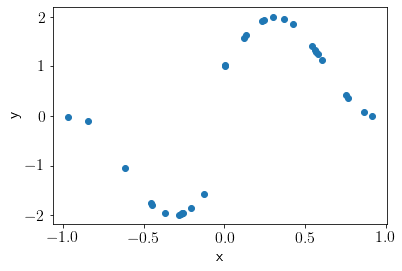

In [3]:
n_train = 30
numpy.random.seed(1234)

# Generate data
def f(X):  # target function
    return numpy.sin(5*X) + numpy.sign(X)

X = numpy.random.uniform(-1, 1, (n_train, 1))  # data
Y = f(X)[:, 0].reshape(-1,1)
plt.scatter(X, Y);
plt.xlabel('x');
plt.ylabel('y');

We will choose 5 latent locations using KMeans clustering

In [4]:
N_local = 5
model = KMeans(n_clusters=N_local)
model.fit(X)
X_local = model.cluster_centers_

We need to learn corresponding lengthscales for `X_local`. Let us define (negative) log likelihood function. We also need a local kernel function to model GP over the lengthscales.

In [5]:
def Local_kernel(Xi, Xj, sigma_l):
    d = np.square(Xi - Xj.T)
    d_scaled = d/sigma_l**2
    
    return np.exp(-d_scaled)

def NLL(params):
    sigma_f, sigma_l, sigma_n = params[:3]
    L_local = params[3:].reshape(-1,1)
    L = np.exp(Local_kernel(X, X_local, sigma_l)@np.linalg.pinv(Local_kernel(X_local, X_local, sigma_l))@np.log(L_local))
    
    K = LLSKernel(X, X, L, L, sigma_f)
    K += np.eye(K.shape[0]) * sigma_n**2
    
    A = 0.5*Y.T@np.linalg.inv(K)@Y + 0.5*np.log(np.linalg.det(K)) + 0.5*np.log(2*np.pi)
    B = 0.5*np.log(np.linalg.det(Local_kernel(X_local, X_local, sigma_l))) + 0.5*np.log(2*np.pi)
    
    return (A+B).squeeze()

Let us find optimal values of paramaters with gradient descent.

In [6]:
opt_fun = np.inf
for seed in range(10):
    numpy.random.seed(seed)
    params = numpy.abs(numpy.random.rand(N_local+3))
    result = minimize(NLL, params, bounds=[[10**-5, 10**5]]*len(params))
    if result.fun < opt_fun:
        opt_fun = result.fun
        opt_result = result

opt_params = opt_result.x

# Optimal values
sigma_f, sigma_l, sigma_n = opt_params[:3]
L_local = opt_params[3:].reshape(-1,1)

Let us predict over the new inputs.

In [7]:
X_new = np.linspace(-1.5, 1.5, 100).reshape(-1,1)

L = np.exp(Local_kernel(X, X_local, sigma_l)@np.linalg.pinv(Local_kernel(X_local, X_local, sigma_l))@np.log(L_local))
L_new = np.exp(Local_kernel(X_new, X_local, sigma_l)@np.linalg.pinv(Local_kernel(X_local, X_local, sigma_l))@np.log(L_local))

K = LLSKernel(X, X, L, L, sigma_f)
K += np.eye(K.shape[0])*sigma_n**2

K_star = LLSKernel(X, X_new, L, L_new, sigma_f)

K_star_star = LLSKernel(X_new, X_new, L_new, L_new, sigma_f)
K_star_star += np.eye(K_star_star.shape[0])*sigma_n**2

Mu_pred = (K_star.T@np.linalg.inv(K)@Y).squeeze()
Mu_cov = K_star_star - K_star.T@np.linalg.inv(K)@K_star

Visualizing predicted mean and variance.

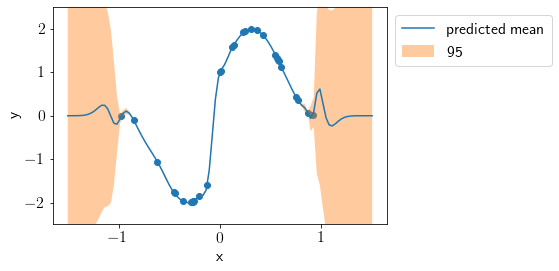

In [8]:
plt.scatter(X, Y)
plt.plot(X_new, Mu_pred, label='predicted mean')

std2 = np.sqrt(Mu_cov.diagonal())*2

plt.fill_between(X_new.squeeze(), Mu_pred-std2, Mu_pred+std2, alpha=0.4, label='95% interval')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2.5, 2.5)
plt.legend(bbox_to_anchor=(1,1));

We see that the fit is good and uncertainty is justified correctly. Let us visualize individual lengthscales.

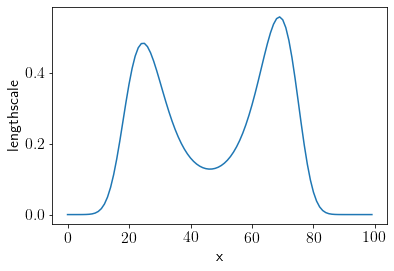

In [9]:
plt.plot(L_new);
plt.xlabel('x')
plt.ylabel('lengthscale');

We see that lengthscales are comparatevely smaller in center to account for sudden jump in dataset. Let us check how stationary GP does on this dataset.

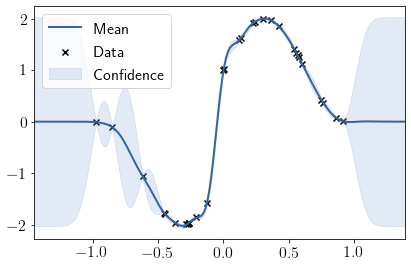

In [10]:
GPModel = GPy.models.GPRegression(X, Y, GPy.kern.RBF(1))
GPModel.optimize_restarts(10, verbose=0)
GPModel.plot();

Comparing the lengthscales.

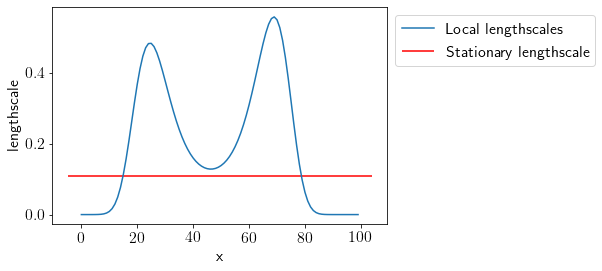

In [11]:
plt.plot(L_new, label='Local lengthscales');
plt.hlines(GPModel.kern.lengthscale, *plt.xlim(), label='Stationary lengthscale', color='r')
plt.xlabel('x')
plt.ylabel('lengthscale');
plt.legend(bbox_to_anchor=(1,1));

We can see that allowing variable lengthscales with a Non-stationary GP results in a better and more interpretable fit.